In [33]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os

In [34]:

# Hyperparameters
lookback_window = 7  # Number of time steps
#I don't have any idea which number is best
# from past test it looks like model has an understanding of general trend of the stock
# but not the specific chracteristics of the stock
# chatgpt recommends me to increase lookback window
input_size = 6        # Number of features (univariate = 1)
output_size = 1       # Predicting one value
hidden_size = 100      # Number of LSTM neurons
num_layers = 10        # Number of LSTM layers

alpha=1 #weight of directional loss
learning_rate = 0.0001
epochs = 50
batch_size = 32

#TODO: USD/TRY exchange rate input
#TODO: Faiz Enflasyon ve Piyasa Katılımcıları Anketi input

#TODO: Takas Verisi (model iyi sonuçlar vermezse son çare olarak kullanılabilir)

#TODO: Vadeli İşlem ve Opsiyon Borsası (VIOP) input (Çok karmaşıklaştırıyor gelecekte belki)
#TODO: Anlık Aracı Kurum Dağılımı  (çok karıştırabilir)



In [35]:
dataLocation="../Data/StandardizedData"
allcsvs=os.listdir(dataLocation)
# turn float64 to float 32

In [36]:
unnecessaryColumns=["Date","Pct_Change"]

from Scaler import Scaler
from sklearn.preprocessing import StandardScaler


# Can't do with minMax scaler we need Z scaler
#Rewrite Time
scaler = Scaler(0,50)
zScalerDic={}


def df_to_X_y(df,zScaler,window_size=5):
  lightWeightDf=df.drop(columns=unnecessaryColumns)
  df_as_np = zScaler.fit_transform(lightWeightDf.to_numpy())
  # df_as_np = lightWeightDf.to_numpy()

  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size,3]
    y.append(label)
  return np.array(X), np.array(y)

In [37]:
XAll = np.zeros(1, dtype=np.int32)
yAll = np.zeros(1, dtype=np.int32)

for i in range(len(allcsvs)):
    rawData=pd.read_csv(os.path.join(dataLocation,allcsvs[i]))
    currentScaler=StandardScaler()
    zScalerDic[allcsvs[i]]=currentScaler
    Xtemp,yTemp=df_to_X_y(rawData, currentScaler, lookback_window)
    nameTemp=np.array([allcsvs[i]]*yTemp.shape[0])

    if(XAll.shape[0] == 1 and yAll.shape[0] == 1):
        XAll=Xtemp
        yAll=yTemp
        nameAll=nameTemp
    else:
        XAll=np.concatenate((XAll,Xtemp),axis=0)
        yAll=np.concatenate((yAll,yTemp),axis=0)
        nameAll=np.concatenate((nameAll,nameTemp),axis=0)
XAll=scaler.fit_transform(XAll)
yAll=scaler.fit_transform(yAll)

# I have to store all of the rawData accurately because I need them afterwards
# or I can make a huge tensor and store all of them in it
# but this raises concerns about the time series consistency

In [38]:
XAll.shape, yAll.shape, nameAll.shape

((57412, 7, 6), (57412,), (57412,))

In [39]:
def shuffle_data(X, y, names):
    """
    Shuffle the data while maintaining the correspondence between X and y.

    Parameters:
    X (numpy.ndarray): The input features tensor.
    y (numpy.ndarray): The target array.

    Returns:
    tuple: Shuffled X and y tensors.
    """
    assert len(X) == len(y), "X and y must have the same length."
    assert len(y) == len(names), "y and names must have the same length."

    # Generate a random permutation of indices
    #TODO add a seed for reproducibility
    #add seed to the code below
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    # print(indices[:5])
    # Shuffle X and y
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    name_shuffled = names[indices]
    
    return X_shuffled, y_shuffled, name_shuffled

In [40]:
X_shuffled, y_shuffled, name_shuffled = shuffle_data(XAll, yAll, nameAll)

In [41]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X_shuffled, y_shuffled, name_shuffled):
        # #NOTE shuffling is automatically done in the dataloader
        # X_shuffled, y_shuffled = shuffle_data(X, y)
        self.dataX = torch.tensor(X_shuffled, dtype=torch.float32)
        self.dataY = torch.tensor(y_shuffled, dtype=torch.float32)
        self.names = name_shuffled
        
    def __len__(self):
        return self.dataX.size(0)

    def __getitem__(self, idx):
        sequence = self.dataX[idx, :]
        target = self.dataY[idx]
        name = self.names[idx]
        return sequence, target, name


#TODO  dropout or batch normalization
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
#try hidden_size*2 if bidirectional is True
    def forward(self, x):
        output, _ = self.lstm(x)
        last_output = output[:, -1, :]  # Take the output at the last time step
        return self.fc(last_output)


In [42]:
import torch.nn.functional as F


#TODO test and utilize
class AttentionMechanism(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionMechanism, self).__init__()
        self.attention_weights = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, lstm_outputs):
        # lstm_outputs: [batch_size, seq_len, hidden_dim]
        attention_scores = self.attention_weights(lstm_outputs).squeeze(-1)  # [batch_size, seq_len]
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, seq_len]
        weighted_output = torch.sum(lstm_outputs * attention_weights.unsqueeze(-1), dim=1)  # [batch_size, hidden_dim]
        return weighted_output, attention_weights
    

class LSTMAttentionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, bidirectional=False):
        super(LSTMAttentionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = AttentionMechanism(hidden_dim * (2 if bidirectional else 1))
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [batch_size, seq_len, hidden_dim]
        attention_out, attention_weights = self.attention(lstm_out)  # [batch_size, hidden_dim], [batch_size, seq_len]
        output = self.fc(attention_out)  # [batch_size, output_dim]
        return output, attention_weights

In [43]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device}")

Using cuda


In [44]:
X_train = X_shuffled[:int(0.8*len(X_shuffled))]
y_train = y_shuffled[:int(0.8*len(y_shuffled))]
name_train = name_shuffled[:int(0.8*len(name_shuffled))]

X_val = X_shuffled[int(0.8*len(X_shuffled)):]
y_val = y_shuffled[int(0.8*len(y_shuffled)):]
name_val = name_shuffled[int(0.8*len(name_shuffled)):]

In [45]:
trainDataset = TimeSeriesDataset(X_train, y_train,name_train)
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=False)
#Dataset for validation
valDataset = TimeSeriesDataset(X_val, y_val,name_val)
val_loader = DataLoader(valDataset, batch_size=batch_size, shuffle=False)

# Cross-validation: On non-overlapping sequential splits for evaluation.

In [46]:
def directional_loss(outputs, targets, sequences):
    # Calculate the direction of predictions and actual values
    pred_dir = (outputs.squeeze() - sequences[:, -1, 3]) >= 0
    true_dir = (targets - sequences[:, -1, 3]) >= 0
    # Penalize mismatched directions
    mismatches = (pred_dir != true_dir).float()
    return mismatches.mean()

In [47]:
def train_one_epoch(model,optimizer,criterion,train_loader):
    model.train()
    model.to(device)
    epoch_loss = 0

    for sequences, targets, name in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        mse=criterion(outputs.squeeze(), targets)
        dir_loss = directional_loss(outputs, targets, sequences)

        loss = mse + alpha * dir_loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    return epoch_loss
    # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")
    


def validate(model,criterion,val_loader):
    model.eval()
    model.to(device)
    val_loss = 0
    DA=0

    with torch.no_grad():
        for sequences, targets, name in val_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            # loss = criterion(outputs.squeeze(), targets)
            dirMatrix=(outputs.squeeze() - sequences[:,-1,3])>=0
            truthDirMatrix=(targets - sequences[:,-1,3])>=0

            DA+=(dirMatrix==truthDirMatrix).sum().item()
            mse=criterion(outputs.squeeze(), targets)
            dir_loss = directional_loss(outputs, targets, sequences)

            loss = mse + alpha * dir_loss

            val_loss += loss.item()
    return val_loss, DA
    # print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

## Some Potenetial Metrics to evaluate models

Profit and Loss (PnL) simulation for trading applications.

In [48]:
# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [49]:

valLosses=[]
trainLosses=[]
DAvals=[]
# Training loop
for epoch in range(epochs):

    epoch_loss=train_one_epoch(model,optimizer,criterion,train_loader)
    val_loss, direction=validate(model,criterion,val_loader)
    valLosses.append(val_loss)
    trainLosses.append(epoch_loss)
    DAvals.append(direction)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}, Directional Accuracy: {direction / len(nameAll):.4f}")

Epoch 1/50, Loss: 145.4162, Validation Loss: 79.8443, Directional Accuracy: 0.0728
Epoch 2/50, Loss: 61.2341, Validation Loss: 24.7746, Directional Accuracy: 0.1253
Epoch 3/50, Loss: 13.5465, Validation Loss: 5.8979, Directional Accuracy: 0.1239
Epoch 4/50, Loss: 4.2917, Validation Loss: 2.2235, Directional Accuracy: 0.0963
Epoch 5/50, Loss: 2.1559, Validation Loss: 1.2046, Directional Accuracy: 0.0758
Epoch 6/50, Loss: 1.2561, Validation Loss: 0.4449, Directional Accuracy: 0.1293
Epoch 7/50, Loss: 0.8507, Validation Loss: 0.2755, Directional Accuracy: 0.1262
Epoch 8/50, Loss: 0.7380, Validation Loss: 0.2237, Directional Accuracy: 0.1268
Epoch 9/50, Loss: 0.6985, Validation Loss: 0.1978, Directional Accuracy: 0.1314
Epoch 10/50, Loss: 0.6762, Validation Loss: 0.1883, Directional Accuracy: 0.1336
Epoch 11/50, Loss: 0.6622, Validation Loss: 0.1814, Directional Accuracy: 0.1347
Epoch 12/50, Loss: 0.6525, Validation Loss: 0.1738, Directional Accuracy: 0.1352
Epoch 13/50, Loss: 0.6444, Vali

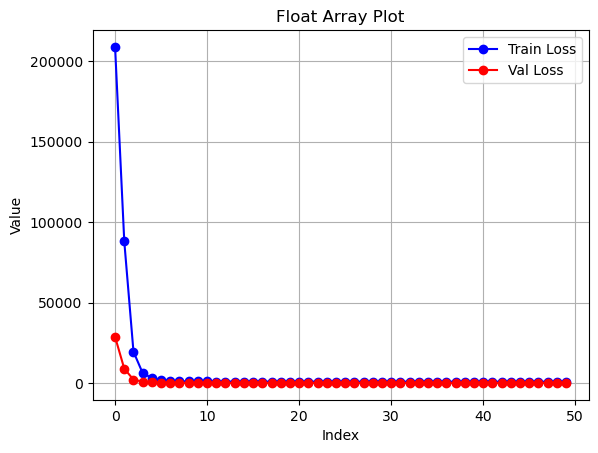

In [50]:
import matplotlib.pyplot as plt
import numpy as np
startPoint=0
# Example float array
val_array = valLosses[startPoint:]
train_array = trainLosses[startPoint:]

# Create an x-axis for the data points
x = np.arange(len(train_array))
y = np.arange(len(val_array))

# Plot the graph
plt.plot(x, train_array, marker='o', linestyle='-', color='b', label='Train Loss')
plt.plot(y, val_array, marker='o', linestyle='-', color='r', label='Val Loss')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Float Array Plot')
plt.legend()

plt.grid(True)
plt.show()

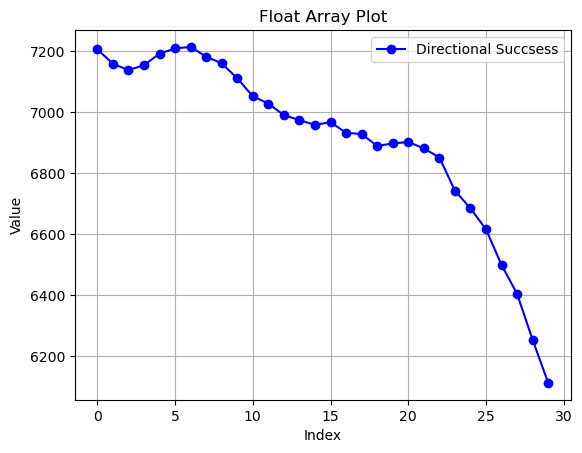

In [51]:
startPoint=20
da_array = DAvals[startPoint:]
# Create an x-axis for the data points
x = np.arange(len(da_array))

# Plot the graph
plt.plot(x, da_array, marker='o', linestyle='-', color='b', label='Directional Succsess')
# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Float Array Plot')
plt.legend()

plt.grid(True)
plt.show()

In [52]:
# Extract one batch of data for testing
model.to(device)
for sequences, targets, name in train_loader:
    testInput = sequences.to(device)  # Sequence data
    # testInput.to(device)
    print(f"Test Input Shape: {testInput.shape}")
    realOutput = targets   # Ground truth output
    break

# Ensure the model is in evaluation mode
model.eval()

# Predict using the model
with torch.no_grad():  # Disable gradient calculations for inference
    predicted = model(testInput).squeeze()  # Forward pass through the model

# Check shapes and results
print(f"Predicted Output Shape: {predicted.shape}")
print(f"First Prediction: {predicted[0].item()}")
print(f"Actual Output (First Target): {realOutput[0].item()}")

predicted
# testInput.shape

Test Input Shape: torch.Size([32, 7, 6])
Predicted Output Shape: torch.Size([32])
First Prediction: 12.088550567626953
Actual Output (First Target): 12.056931495666504


tensor([12.0886, 10.3268, 35.1022,  8.7907, 13.2710, 13.5064, 12.2604, 11.0673,
        10.7679, 11.7571, 31.7134, 13.4759, 12.5459, 12.3063, 10.7874, 23.5145,
        11.3462, 22.6921, 19.9691, 29.9556, 21.6570, 12.4420, 22.6282, 32.8167,
        14.0113, 15.1625, 13.0469, 20.0320, 13.6726, 10.8335, 35.3725, 10.9141],
       device='cuda:0')

In [53]:
realOutput

tensor([12.0569, 10.3236, 34.0482,  8.6764, 13.1621, 13.3180, 12.1587, 11.0014,
        10.7556, 11.6829, 30.9787, 13.2700, 12.4440, 12.2816, 10.7637, 23.8408,
        11.3111, 22.0922, 19.4094, 29.9829, 21.2527, 12.4007, 22.6313, 32.8407,
        13.7339, 15.3199, 12.8578, 19.8841, 13.6654, 10.8272, 34.9865, 10.9540])